In [3]:
from scipy.spatial import Voronoi

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 150

import pandas as pd
import os

import vis.Visualization as visual
import vis.CommunityWise as cwise
import vis.Utils as utils
import vis.ConsensusClustering as cc

from datetime import datetime

import networkx as nx
import community as community_louvain

from datetime import datetime

from sklearn.neighbors import KDTree

In [4]:
# These are the folders where we'll find the grids or community lists
gridFolder = 'grids'
communityFolder = 'communities'

# This is the number of community detections to perform in the last step
numCommunityDetections = 3

# I will assume there a few values of the parameter that give reasonable results,
# and we will onyl sample those
goodParameterValues = ['0.80', '0.90']

pointArr, communityArr = utils.loadCommunityData(gridFolder, communityFolder, goodParameterValues)

# Select just a few communities to average over for testing
goodCommunities = np.arange(3) #[0, 3, 6, 9]
pointArr = np.array(pointArr, dtype='object')[goodCommunities]
communityArr = np.array(communityArr, dtype='object')[goodCommunities]

# Generate some colors to use for each set of communities
randomColors = [visual.genRandomColors(max(communityArr[i]), 20) for i in range(len(goodCommunities))]

Misalignment or invalid communities: DM11G0.80.csv
Misalignment or invalid communities: DM11G0.90.csv


IndexError: list index out of range

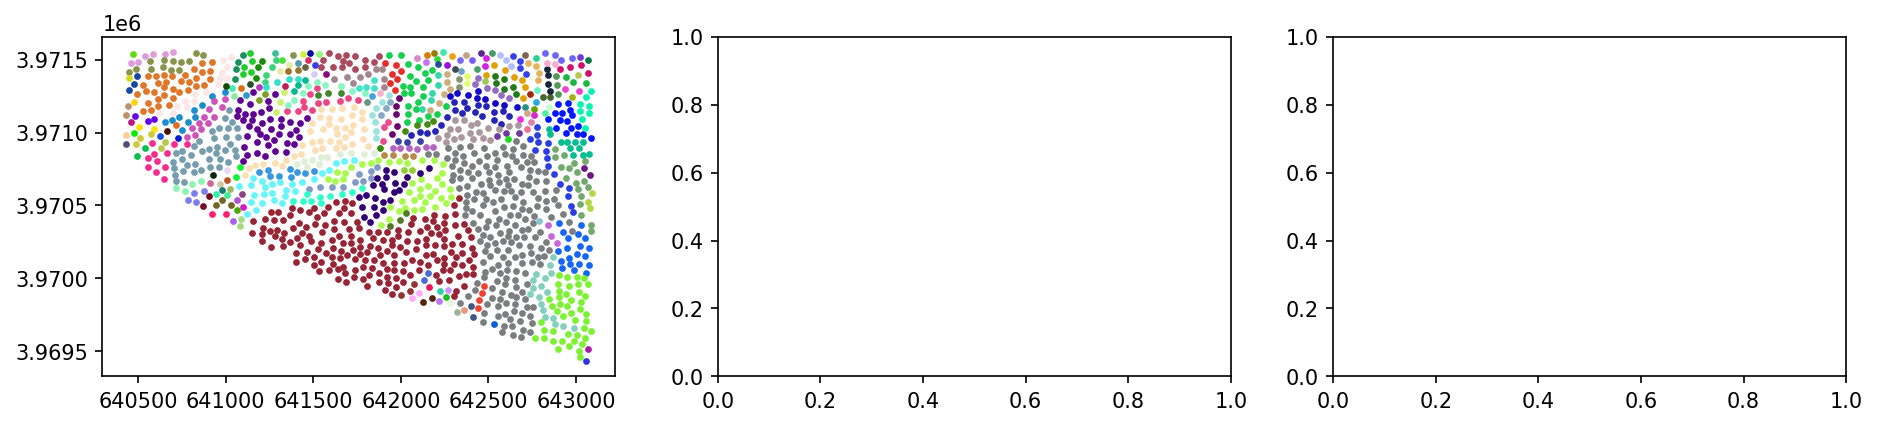

In [3]:
fig, ax = plt.subplots(1, len(communityArr), figsize=(len(communityArr)*5, 3))

for i in range(len(communityArr)):
    visual.drawPoints(ax[i], pointArr[i], communityArr[i], randomColors[i], s=5)
fig.tight_layout()
plt.show()

In [5]:
gridPoints = 50

def generateUniformGrid(originalPoints, gridPoints, returnNeighbors=True):
    # Now we create a uniform square grid

    # Not exactly the most efficient method to find the extreme points across
    # all configurations, but it works well enough
    flattenedX = []
    flattenedY = []

    for i in range(len(communityArr)):
        for j in range(len(originalPoints[i])):
            flattenedX.append(originalPoints[i][j,0])
            flattenedY.append(originalPoints[i][j,1])

    uniformX = np.linspace(min(flattenedX), max(flattenedX), gridPoints)
    uniformY = np.linspace(min(flattenedY), max(flattenedY), gridPoints)

    uniformGridPoints = np.zeros([gridPoints, gridPoints, 2])
    neighborDirections = [[1,0], [-1,0], [0,1], [0,-1], [1,1], [1,-1], [-1,1], [-1,-1]]
    gridPointNeighbors = [[] for i in range(gridPoints*gridPoints)]
    
    for y in range(gridPoints):
        for x in range(gridPoints):
            uniformGridPoints[y,x] = [uniformX[x], uniformY[y]]
            for nndir in neighborDirections:
                if ((x+nndir[0] >= 0 and x+nndir[0] < len(uniformX)) and (y+nndir[1] >= 0 and y+nndir[1] < len(uniformY))):
                    gridPointNeighbors[y*gridPoints+x].append(np.array([uniformX[x+nndir[0]], uniformY[y+nndir[1]]]))

    uniformGridPoints = uniformGridPoints.reshape([gridPoints*gridPoints, 2])

    return uniformGridPoints, gridPointNeighbors

uniformGridPoints, gridPointNeighbors = generateUniformGrid(pointArr, gridPoints)

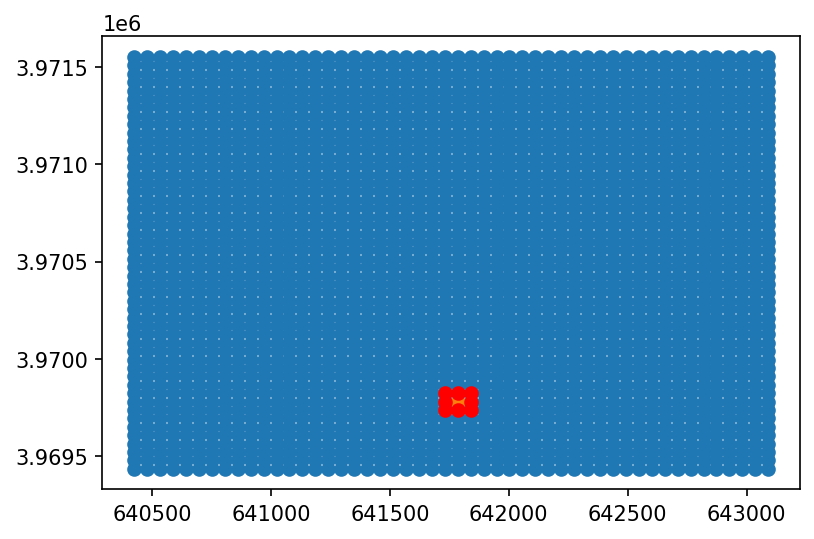

In [88]:
index = 425
plt.scatter(uniformGridPoints[:,0], uniformGridPoints[:,1])
plt.scatter(uniformGridPoints[index][0], uniformGridPoints[index][1])
#for i in uniformNeighborIndices[index]:
#    plt.scatter(uniformPoints[i][0], uniformPoints[i][1], c='red')
for p in gridPointNeighbors[index]:
    plt.scatter(p[0], p[1], c='red')
#plt.scatter(uniformNeighbors[index][:][0], uniformNeighbors[index][:][1])
plt.show()

In [6]:
from vis.Visualization import isInsideHull, intersection

def assignCommunitiesAndNeighbors(points, communityBounds, hullBounds, gridPointNeighbors):

    # Make sure our points are in a list, so that we can delete items
    pointArr = list(points.copy())
    neighborsArr = list(gridPointNeighbors.copy())
    #print(neighborsArr)
    # First, we create a list of communities based on their size
    # since this should speed up our assignment
    
    # We take the size of the communities by the number of lines that compose
    # them. This isn't a perfect algorithm, but it is by far the fastest,
    # and there should mostly be a correlation between the two metrics, since
    # we won't have any long straight edges in our region
    communitySizes = np.array([len(x) for x in communityBounds])
    sizeOrderedIndices = np.argsort(communitySizes)[::-1]
    
    # Remove all points that are outside of the hull
    for i in range(len(pointArr)-1, -1, -1):
        if not isInsideHull(pointArr[i], hullBounds):
            del pointArr[i]
            del neighborsArr[i]
    
    # We don't know if all of our points will actually be in any community
    # (They could be outside the entire region) so we add points as we go
    assignedPoints = []
    assignedCommunities = []
    assignedNeighbors = []
    
    # Now we sort through each community and check if each point is inside
    # We want to remove points once they have been assigned, so as to speed up
    # the process 
    for i in sizeOrderedIndices:
        pointsToRemove = []
        
        for j in range(len(pointArr)):
            if isInsideHull(pointArr[j], communityBounds[i]):
                assignedPoints.append(pointArr[j])
                assignedCommunities.append(i)
                assignedNeighbors.append(neighborsArr[j])
                pointsToRemove.append(j)
                
        for j in sorted(pointsToRemove, reverse=True):
            del pointArr[j]
            # Deleting the value here doesn't speed up anything
            # but we need to do it to keep the indexing consistent across both arrays
            del neighborsArr[j] 
        
    # Finally, we have to reorder the points since the order got
    # all messed up because of the optimization
    sortablePoints = np.array([(assignedPoints[i][0], assignedPoints[i][1]) for i in range(len(assignedPoints))], dtype=[('x', float), ('y', float)])
    sortedOrder = np.argsort(sortablePoints, order=('x', 'y'))

    assignedPoints = np.array(assignedPoints)[sortedOrder]
    assignedCommunities = np.array(assignedCommunities, dtype=int)[sortedOrder]
    assignedNeighbors = [assignedNeighbors[i] for i in sortedOrder]
    
    return assignedPoints, assignedCommunities, assignedNeighbors

In [8]:
# Normalize the node points for each one
hullLines = []
communityBoundaries = []

uniformPointArr = []
uniformCommunityArr = []
uniformNeighborsArr = []

for i in range(len(communityArr)):
    # Calculate the boundaries for each detection
    # NOTE: This may take a while, about 1-2 minutes per detection for 50 gridPoints
    currVor = Voronoi(pointArr[i])
    currHullLines, currHullLineCommunities = cwise.concaveHull(pointArr[i], communityArr[i])
    currCommunityBoundaries = cwise.vorToCommunityBounds(currVor, communityArr[i], currHullLines, currHullLineCommunities)
    print('finished prelim calculations')
    # Make sure that there aren't any weird things going on with this detection
    # Sometimes you will get artifacts of something (idk what) so we just throw those away
    badDetection = False
    for j in range(len(currCommunityBoundaries)):
        if len(currCommunityBoundaries[j]) == 0:
            badDetection = True
            break
    if badDetection:
        print(f'Warning: bad detection at index {i}')
        continue
        
    currUniformPoints, currUniformCommunities = cwise.assignCommunities(uniformGridPoints, currCommunityBoundaries, currHullLines)
    #currUniformPoints, currUniformCommunities, currNeighbors = assignCommunitiesAndNeighbors(uniformGridPoints,
    #                                                                                               currCommunityBoundaries, currHullLines, gridPointNeighbors)
#     index = 425
#     plt.scatter(currUniformPoints[:,0], currUniformPoints[:,1])
#     plt.scatter(currUniformPoints[index][0], currUniformPoints[index][1])
#     #for i in uniformNeighborIndices[index]:
#     #    plt.scatter(uniformPoints[i][0], uniformPoints[i][1], c='red')
#     for p in currNeighbors[index]:
#         plt.scatter(p[0], p[1], c='red')
#     #plt.scatter(uniformNeighbors[index][:][0], uniformNeighbors[index][:][1])
#     plt.show()
    
    # And save some things
    hullLines.append(currHullLines)
    communityBoundaries.append(currCommunityBoundaries)
    uniformPointArr.append(currUniformPoints)
    uniformCommunityArr.append(currUniformCommunities)
    #uniformNeighborsArr.append(currNeighbors)
    
# We also have to make sure that each uniform set of points
# is exactly the same, since the slight variations in boundary sizes
# could make a difference
pointCounts = [len(uniformPointArr[i]) for i in range(len(uniformPointArr))]
if len(np.unique(pointCounts)) > 1:
    # For each point, make sure it exists in the other lists
    for i in range(len(uniformPointArr)):
        # Count backwards here, so we can remove
        for j in range(len(uniformPointArr[i])-1, -1, -1):
            if False in [uniformPointArr[i][j] in uniformPointArr[k] for k in range(len(uniformPointArr))]:
                del uniformPointArr[i][j]
                del uniformNeighborsArr[i][j]
                
                
# # All of the points should now be the same, so we can just take the first element of the array
# uniformPoints = uniformPointArr[0]
# uniformNeighbors = uniformNeighborsArr[0]

# uniformNeighborIndices = [[] for i in range(len(uniformPoints))]
# pointToIndexDict = dict(zip([str(p) for p in uniformPoints], range(len(uniformPoints))))
# for i in range(len(uniformPoints)):
#     for nnp in uniformNeighbors[i]:
#         if str(nnp) in pointToIndexDict.keys():
#             uniformNeighborIndices[i].append(pointToIndexDict[str(nnp)])

finished prelim calculations
finished prelim calculations
finished prelim calculations


1639


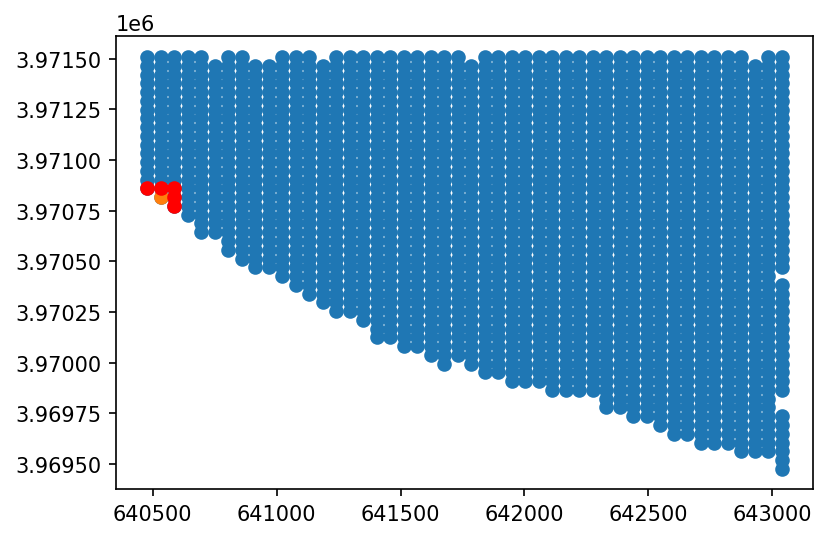

In [108]:
print(len(uniformPoints))
#print(uniformNeighborIndices)

index = 16
plt.scatter(uniformPoints[:,0], uniformPoints[:,1])
plt.scatter(uniformPoints[index][0], uniformPoints[index][1])
for i in uniformNeighborIndices[index]:
    plt.scatter(uniformPoints[i][0], uniformPoints[i][1], c='red')
#for p in uniformNeighbors[index]:
#    plt.scatter(p[0], p[1], c='red')
#plt.scatter(uniformNeighbors[index][:][0], uniformNeighbors[index][:][1])
plt.show()

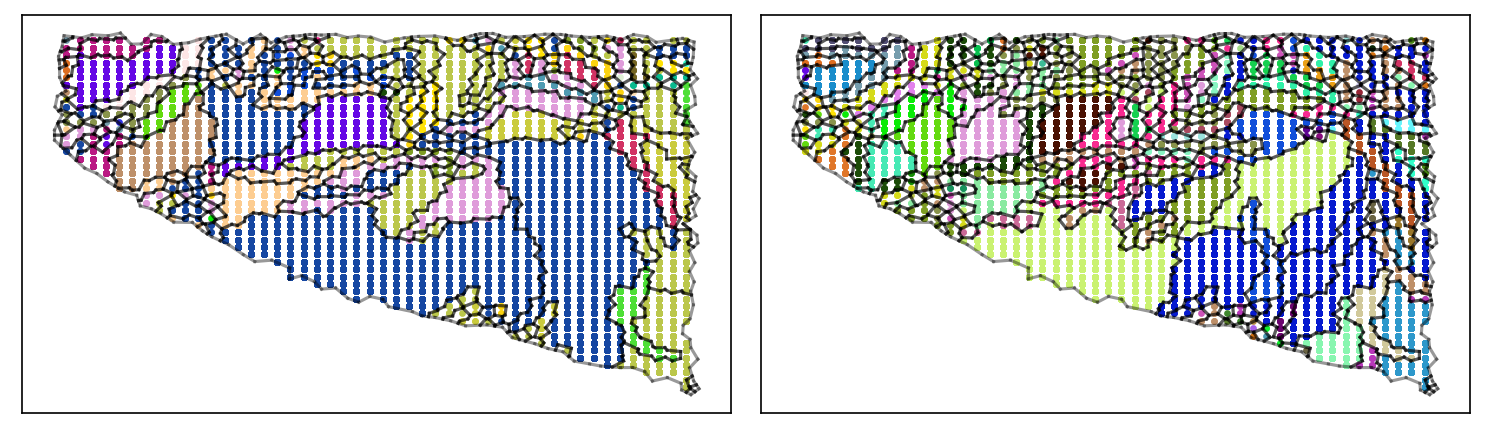

In [49]:
fig, ax = plt.subplots(1, len(uniformCommunityArr), figsize=(len(uniformCommunityArr)*5, 3))

for i in range(len(uniformCommunityArr)):
    visual.drawPoints(ax[i], uniformPointArr[i], uniformCommunityArr[i], randomColors[i], s=5)
    for j in range(len(communityBoundaries[i])):
        visual.drawLines(ax[i], communityBoundaries[i][j], opacity=.4)
fig.tight_layout()
plt.show()

In [24]:
def _dist(p1, p2):
    """
    Simple euclidean distance between two points
    """
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def calculateConsensusMatrix(communityAssignments):
    # Mostly just for testing, so I can use a single community detection
    if len(np.shape(communityAssignments)) == 1:
        communityAssignments = [communityAssignments]

    numPoints = len(communityAssignments[0])
    consensusMatrix = np.zeros([numPoints, numPoints])

    # Iterate over every detection
    # Quite inefficient, but very simple at least
    for i in range(numPoints):
        for j in range(numPoints):
            consensusMatrix[i,j] = len([0 for k in range(len(communityAssignments)) if communityAssignments[k][i] == communityAssignments[k][j]])


    return consensusMatrix/len(communityAssignments)

def findNodeNeighbors(gridPositions, numNeighbors=8):
    # Use a KD Tree to find the neighbors (really) efficiently
    # I don't actually know the complexity of searching a kd tree
    # but judging by the time it takes to do it, it very well could be O(1)
    kdTree = KDTree(gridPositions, leaf_size=2)
    dist, ind = kdTree.query(gridPositions, k=numNeighbors+1)
    # The first index will always be the point itself, so we ignore that        
    return ind[:,1:]

def calculateFastConsensusMatrix(communityAssignments, neighborIndices, m=None):

    numPoints = len(communityAssignments[0])
    consensusMatrix = np.zeros([numPoints, numPoints])

    if m == None:
        m = numPoints

    for i in range(numPoints):
        for nn in neighborIndices[i]:
            consensusMatrix[i][nn] = len([0 for k in range(len(communityAssignments)) if communityAssignments[k][i] == communityAssignments[k][nn]])
               
    for i in range(m):
        nodeSelection = np.random.randint(numPoints)
        n1, n2 = np.random.choice(neighborIndices[nodeSelection], size=2)
        
        if consensusMatrix[n1][n2] == 0:
            consensusMatrix[n1][n2] = len([0 for k in range(len(communityAssignments)) if communityAssignments[k][n1] == communityAssignments[k][n2]])

    consensusMatrix /= len(communityAssignments)

    return consensusMatrix

Took 0:00:02.133951
Took 0:00:00.004494
Took 0:00:00.048823


KeyboardInterrupt: 

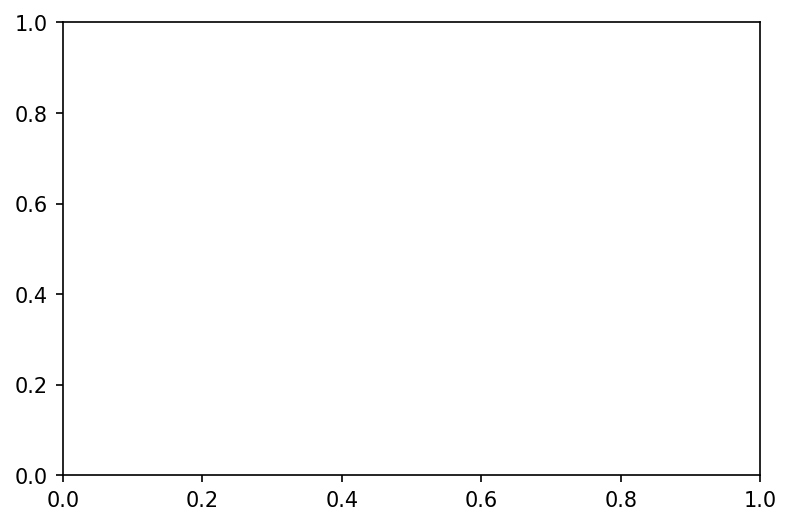

In [25]:

start = datetime.now()
consensusMatrix = cc.calculateConsensusMatrix(uniformCommunityArr)
print(f'Took {(datetime.now() - start)}')
start = datetime.now()
uniformNeighborIndices = findNodeNeighbors(uniformPointArr[0])
print(f'Took {(datetime.now() - start)}')
start = datetime.now()
fastConsensusMatrix = calculateFastConsensusMatrix(uniformCommunityArr, uniformNeighborIndices)
print(f'Took {(datetime.now() - start)}')

plt.pcolor(consensusMatrix)
plt.colorbar()
plt.show()

plt.pcolor(fastConsensusMatrix)
plt.colorbar()
plt.show()

# Now we can create a graph from the consensus matrix
graph = nx.from_numpy_matrix(consensusMatrix)
fastGraph = nx.from_numpy_matrix(fastConsensusMatrix)
finalPoints = uniformPointArr[0]

partitionArr = []
fastPartitionArr = []

genlouvainResolutions = np.random.normal(.75, .05, size=[3])
for i in range(numCommunityDetections):
    # Perform the community detection
    currPartition = community_louvain.best_partition(graph, resolution=genlouvainResolutions[i], randomize=True)
    currPartition = list(currPartition.values())
    currPartition = cwise.patchCommunityIndices(currPartition)

    fastCurrPartition = community_louvain.best_partition(fastGraph, resolution=genlouvainResolutions[i], randomize=True)
    fastCurrPartition = list(fastCurrPartition.values())
    fastCurrPartition = cwise.patchCommunityIndices(fastCurrPartition)
    
    partitionArr.append(currPartition)
    fastPartitionArr.append(fastCurrPartition)

[[   1   17   16 ...   19   35   34]
 [   2    0   18 ...    3   20   16]
 [   1    3   19 ...    4    0   21]
 ...
 [1637 1635 1591 ... 1634 1638 1589]
 [1636 1638 1592 ... 1635 1590 1547]
 [1637 1593 1592 ... 1547 1635 1546]]


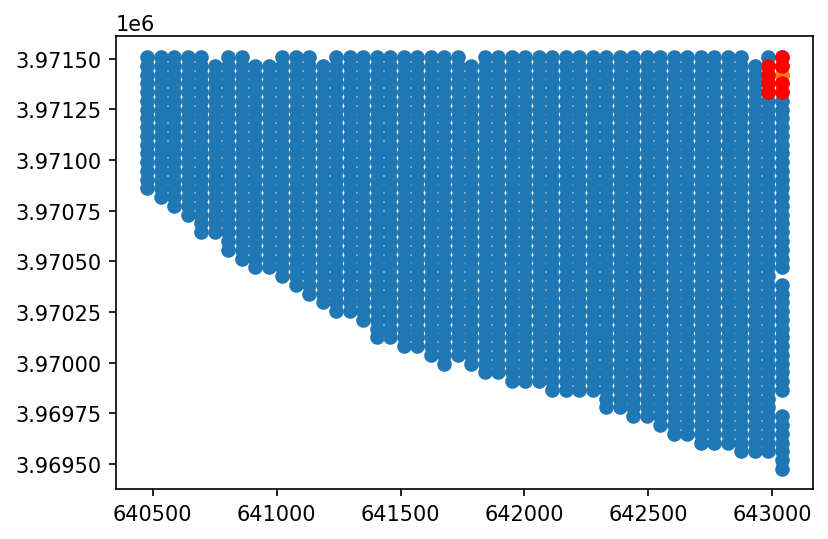

In [32]:
print(uniformNeighborIndices)
uniformPoints = uniformPointArr[0]

index = -3
plt.scatter(uniformPoints[:,0], uniformPoints[:,1])
plt.scatter(uniformPoints[index][0], uniformPoints[index][1])
for i in uniformNeighborIndices[index]:
    plt.scatter(uniformPoints[i][0], uniformPoints[i][1], c='red')
#for p in uniformNeighbors[index]:
#    plt.scatter(p[0], p[1], c='red')
#plt.scatter(uniformNeighbors[index][:][0], uniformNeighbors[index][:][1])
plt.show()

In [1]:
fig, ax = plt.subplots(1, len(partitionArr), figsize=(len(partitionArr)*5, 3))

finalRandomColors = [visual.genRandomColors(max(partitionArr[i])) for i in range(len(partitionArr))]

for i in range(len(partitionArr)):
    visual.drawPoints(ax[i], finalPoints, partitionArr[i], randomColors[i], s=5)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, len(fastPartitionArr), figsize=(len(fastPartitionArr)*5, 3))

finalRandomColors = [visual.genRandomColors(max(fastPartitionArr[i])) for i in range(len(fastPartitionArr))]

for i in range(len(partitionArr)):
    visual.drawPoints(ax[i], finalPoints, fastPartitionArr[i], randomColors[i], s=5)
fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined